# Task-specific knowledge distillation with BERT, Transformers & Amazon SageMaker
### Text Classification Example using `Roberta` as Teacher and `BERT-Tiny` as Student

# Introduction

Welcome to this end-to-end multilingual Text-Classification example using PyTorch. In this demo, we will use the Hugging Faces `transformers` and `datasets` library together with `Pytorch` to fine-tune a multilingual transformer for text-classification. This example is a derived version of the [text-classificiaton.ipynb](https://github.com/philschmid/transformers-pytorch-text-classification/blob/main/text-classification.ipynb) notebook and uses Amazon SageMaker for distributed training. In the [text-classificiaton.ipynb](https://github.com/philschmid/transformers-pytorch-text-classification/blob/main/text-classification.ipynb) we showed how to fine-tune `distilbert-base-multilingual-cased` on the `amazon_reviews_multi` dataset for `sentiment-analysis`. This dataset has over 1.2 million data points, which is huge. Running training would take on 1x NVIDIA V100 takes around 6,5h for `batch_size` 16, which is quite long.

To scale and accelerate our training we will use [Amazon SageMaker](https://aws.amazon.com/de/sagemaker/), which provides two strategies for [distributed training](https://huggingface.co/docs/sagemaker/train#distributed-training), [data parallelism](https://huggingface.co/docs/sagemaker/train#data-parallelism) and model parallelism. Data parallelism splits a training set across several GPUs, while [model parallelism](https://huggingface.co/docs/sagemaker/train#model-parallelism) splits a model across several GPUs. We are going to use [SageMaker Data Parallelism](https://aws.amazon.com/blogs/aws/managed-data-parallelism-in-amazon-sagemaker-simplifies-training-on-large-datasets/), which has been built into the [Trainer](https://huggingface.co/transformers/main_classes/trainer.html) API. To be able use data-parallelism we only have to define the `distribution` parameter in our `HuggingFace` estimator.

I moved the "training" part of the [text-classificiaton.ipynb](https://github.com/philschmid/transformers-pytorch-text-classification/blob/main/text-classification.ipynb) notebook into a separate training script [train.py](./scripts/train.py), which accepts the same hyperparameter and can be run on Amazon SageMaker using the `HuggingFace` estimator. 

Our goal is to decrease the training duration by scaling our global/effective batch size from 16 up to 128, which is 8x bigger than before. For monitoring our training we will use the new Training Metrics support by the [Hugging Face Hub](hf.co/models) 

### Installation

In [ ]:
#!pip install sagemaker 
!pip install transformers datasets tensorboard datasets[s3] --upgrade

This example will use the [Hugging Face Hub](https://huggingface.co/models) as remote model versioning service. To be able to push our model to the Hub, you need to register on the [Hugging Face](https://huggingface.co/join). 
If you already have an account you can skip this step. 
After you have an account, we will use the `notebook_login` util from the `huggingface_hub` package to log into our account and store our token (access key) on the disk. 

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Setup & Configuration

In this step we will define global configurations and parameters, which are used across the whole end-to-end fine-tuning proccess, e.g. `tokenizer` and `model` we will use. 

In [ ]:
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

_Note: The execution role is only available when running a notebook within SageMaker (SageMaker Notebook Instances or Studio). If you run `get_execution_role` in a notebook not on SageMaker, expect a region error._

You can comment in the cell below and provide a an IAM Role name with SageMaker permissions to setup your environment out side of SageMaker.

In [9]:
# import sagemaker
# import boto3
# import os

# os.environ["AWS_DEFAULT_REGION"]="your-region"

# # This ROLE needs to exists with your associated AWS Credentials and needs permission for SageMaker
# ROLE_NAME='role-name-of-your-iam-role-with-right-permissions'

# iam_client = boto3.client('iam')
# role = iam_client.get_role(RoleName=ROLE_NAME)['Role']['Arn']
# sess = sagemaker.Session()

# print(f"sagemaker role arn: {role}")
# print(f"sagemaker bucket: {sess.default_bucket()}")
# print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::558105141721:role/sagemaker_execution_role
sagemaker bucket: sagemaker-us-east-1-558105141721
sagemaker session region: us-east-1


In this example are we going to fine-tune the [distilbert-base-multilingual-cased](https://huggingface.co/distilbert-base-multilingual-cased) a multilingual DistilBERT model. 

In [1]:
model_id = "distilbert-base-multilingual-cased"

# name for our repository on the hub
model_name = model_id.split("/")[-1] if "/" in model_id else model_id
repo_name = f"{model_name}-sentiment"

## Dataset & Pre-processing

As Dataset we will use the [amazon_reviews_multi](https://huggingface.co/datasets/amazon_reviews_multi) a multilingual text-classification. The dataset contains reviews in English, Japanese, German, French, Chinese and Spanish, collected between November 1, 2015 and November 1, 2019. Each record in the dataset contains the review text, the review title, the star rating, an anonymized reviewer ID, an anonymized product ID and the coarse-grained product category (e.g. ‘books’, ‘appliances’, etc.) The corpus is balanced across stars, so each star rating constitutes 20% of the reviews in each language.


In [2]:
dataset_id="amazon_reviews_multi"
dataset_config="all_languages"

seed=33

To load the `amazon_reviews_multi` dataset, we use the `load_dataset()` method from the 🤗 Datasets library.


In [3]:
from datasets import load_dataset

dataset = load_dataset(dataset_id,dataset_config)

Reusing dataset amazon_reviews_multi (/home/ubuntu/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

### Pre-processing & Tokenization

The [amazon_reviews_multi](https://huggingface.co/datasets/amazon_reviews_multi) has 5 classes (`stars`) to match those into a `sentiment-analysis` task we will map those star ratings to the following classes `labels`:
* `[1-2]`: `Negative`
* `[3]`: `Neutral`
* `[4-5]`: `Positive`

Those `labels` can be later used to create a user friendly output after we fine-tuned our model. 

In [4]:
from datasets import ClassLabel

def map_start_to_label(review):
  if review["stars"] < 3:
    review["stars"] = 0
  elif review["stars"] == 3:
    review["stars"] = 1
  else: 
    review["stars"] = 2
  return review

# convert 1-5 star reviews to 0,1,2
dataset = dataset.map(map_start_to_label)

# convert feature from Value to ClassLabel
class_feature =  ClassLabel(names=['negative','neutral', 'positive'])
dataset = dataset.cast_column("stars", class_feature)

# rename our target column to labels
dataset = dataset.rename_column("stars","labels")

# drop columns that are not needed
dataset = dataset.remove_columns(['review_id', 'product_id', 'reviewer_id', 'review_title', 'language', 'product_category'])

dataset["train"].features


Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-da69b832ccae3902.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-c090e61da6df9ce2.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-e24978bae26959c1.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-3d48141565c7759b.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87d

{'labels': ClassLabel(num_classes=3, names=['negative', 'neutral', 'positive'], names_file=None, id=None),
 'review_body': Value(dtype='string', id=None)}

Before we prepare the dataset for training. Lets take a quick look at the class distribution of the dataset.

array([[<AxesSubplot:title={'center':'labels'}>]], dtype=object)

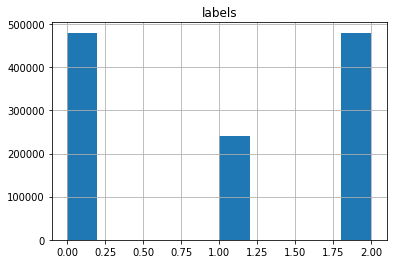

In [5]:
import pandas as pd

df = dataset["train"].to_pandas()

df.hist()

The Distribution is not perfect, but lets give it a try and improve on this later.

To train our model we need to convert our "Natural Language" to token IDs. This is done by a 🤗 Transformers Tokenizer which will tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary). If you are not sure what this means check out [chapter 6](https://huggingface.co/course/chapter6/1?fw=tf) of the Hugging Face Course.


In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id)

Additionally we add the `truncation=True` and `max_length=512` to align the length and truncate texts that are bigger than the maximum size allowed by the model. 

In [ ]:
def process(examples):
    tokenized_inputs = tokenizer(
        examples["review_body"], truncation=True, max_length=512
    )
    return tokenized_inputs

tokenized_datasets = dataset.map(process, batched=True)
tokenized_datasets["train"].features

Before we can start our distributed Training, we need to upload our already pre-processed dataset to Amazon S3. Therefore we will use the built-in utils of `datasets`

In [10]:
import botocore
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()  

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{dataset_id}/train'
tokenized_datasets["train"].save_to_disk(training_input_path, fs=s3)

# save validation_dataset to s3
eval_input_path = f's3://{sess.default_bucket()}/{dataset_id}/test'
tokenized_datasets["validation"].save_to_disk(eval_input_path, fs=s3)

## Creating an Estimator and start a training job


Last step before we can start our managed training is to define our Hyperparameters, create our sagemaker `HuggingFace` estimator and configure distributed training.

In [19]:
from sagemaker.huggingface import HuggingFace
from huggingface_hub import HfFolder

# hyperparameters, which are passed into the training job
hyperparameters={
    'model_id':'distilbert-base-multilingual-cased',           
    'epochs': 3,                                    
    'per_device_train_batch_size': 16,                         
    'per_device_eval_batch_size': 16,                          
    'learning_rate': 3e-5*8,                          
    'fp16': True,            
    # logging & evaluation strategie
    'strategy':'steps',
    'steps':5_000,
    'save_total_limit':2,
    'load_best_model_at_end':True,
    'metric_for_best_model':"f1",
    # push to hub config
    'push_to_hub': True,                            
    'hub_model_id': 'distilbert-base-multilingual-cased-sentiment-2', 
    'hub_token': HfFolder.get_token()               
}

# configuration for running training on smdistributed Data Parallel
distribution = {'smdistributed':{'dataparallel':{ 'enabled': True }}}

# create the Estimator
huggingface_estimator = HuggingFace(
    entry_point          = 'train.py',        
    source_dir           = './scripts',       
    instance_type        = 'ml.p3.16xlarge',   
    instance_count       = 1,                 
    role                 = role,              
    transformers_version = '4.12',            
    pytorch_version      = '1.9',             
    py_version           = 'py38',            
    hyperparameters      = hyperparameters,   
    distribution         = distribution
)

Since, we are using SageMaker Data Parallelism our total_batch_size will be per_device_train_batch_size * n_gpus.



In [20]:
# define a data input dictonary with our uploaded s3 uris
data = {
    'train': training_input_path,
    'eval': eval_input_path
}

# starting the train job with our uploaded datasets as input
# setting wait to False to not expose the HF Token
huggingface_estimator.fit(data,wait=False)

Since we are using the Hugging Face Hub intergration with Tensorboard we can inspect our progress directly on the hub, as well as testing checkpoints during the training.

In [ ]:
from huggingface_hub import HfApi

whoami = HfApi().whoami()
username = whoami['name']

print(f"https://huggingface.co/{username}/{hyperparameters['hub_model_id']}")

![tensorboard](./imgs/tensorboard.png)